In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3716

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - loss: 0.3301
Average validation loss: 0.6283745765686035
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - loss: 0.3301 - val_loss: 0.6284
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - loss: 0.2526 - val_loss: 0.6284
Average validation loss: 0.4530327320098877
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - loss: 0.2526 - val_loss: 0.5407
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step - loss: 0.2025 - val_loss: 0.5407
Average validation loss: 0.215336412191391
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 552ms/step - loss: 0.2025 - val_loss: 0.4322
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segfor

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 796ms/step - loss: 0.0453
Average validation loss: 0.26953573524951935
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 807ms/step - loss: 0.0453 - val_loss: 0.2695
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 795ms/step - loss: 0.0402 - val_loss: 0.2695
Average validation loss: 0.4674481451511383
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 812ms/step - loss: 0.0402 - val_loss: 0.3685
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 812ms/step - loss: 0.0363 - val_loss: 0.3685
Average validation loss: 0.22810408473014832
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 823ms/step - loss: 0.0363 - val_loss: 0.3217
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_10.pth'.
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 830ms/step - loss: 0.0340 - val_loss: 0.3217
Average validation los

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 836ms/step - loss: 0.0219
Average validation loss: 0.0542426531513532
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 850ms/step - loss: 0.0219 - val_loss: 0.0542
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 902ms/step - loss: 0.0195 - val_loss: 0.0542
Average validation loss: 0.0904782060533762
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 915ms/step - loss: 0.0195 - val_loss: 0.0724
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 987ms/step - loss: 0.0168 - val_loss: 0.0724
Average validation loss: 0.057854655819634594
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.0168 - val_loss: 0.0675   
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 831ms/step - loss: 0.0150 - val_loss: 0.0675
Average validation loss: 0.03607946137587229
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 845ms/step - loss: 0.0150 - val_loss: 0.0597
Saved model weights to 'c:\天_11157065\git\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 796ms/step - loss: 0.0068
Average validation loss: 0.009252309042494744
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 807ms/step - loss: 0.0068 - val_loss: 0.0093
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 880ms/step - loss: 0.0061 - val_loss: 0.0093
Average validation loss: 0.016432124364655465
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 894ms/step - loss: 0.0061 - val_loss: 0.0128
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 816ms/step - loss: 0.0052 - val_loss: 0.0128
Average validation loss: 0.028519162675365806
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 829ms/step - loss: 0.0052 - val_loss: 0.0181
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 829ms/step - loss: 0.0051 - val_loss: 0.0181
Average validation loss: 0.019432240282185376
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 842ms/step - loss: 0.0051 - val_loss: 0.0184
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 833ms/step - loss: 0.0160
Average validation loss: 0.015583888441324235
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 846ms/step - loss: 0.0160 - val_loss: 0.0156
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 817ms/step - loss: 0.0105 - val_loss: 0.0156
Average validation loss: 0.01416559866629541
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 829ms/step - loss: 0.0105 - val_loss: 0.0149
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 789ms/step - loss: 0.0082 - val_loss: 0.0149
Average validation loss: 0.01164158615283668
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 801ms/step - loss: 0.0082 - val_loss: 0.0138
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segform

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 798ms/step - loss: 0.0139
Average validation loss: 0.011522271553985775
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 809ms/step - loss: 0.0139 - val_loss: 0.0115
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 980ms/step - loss: 0.0106 - val_loss: 0.0115
Average validation loss: 0.017996718369734783
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 993ms/step - loss: 0.0106 - val_loss: 0.0148
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 861ms/step - loss: 0.0087 - val_loss: 0.0148
Average validation loss: 0.004421910901631539
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 873ms/step - loss: 0.0087 - val_loss: 0.0113
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 795ms/step - loss: 0.0074 - val_loss: 0.0113
Av

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 795ms/step - loss: 0.0122
Average validation loss: 0.039858691534027456
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 808ms/step - loss: 0.0122 - val_loss: 0.0399
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 812ms/step - loss: 0.0096 - val_loss: 0.0399
Average validation loss: 0.02894890233874321
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 826ms/step - loss: 0.0096 - val_loss: 0.0344
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 98s 821ms/step - loss: 0.0082 - val_loss: 0.0344
Average validation loss: 0.020634066517231986
40/40 ━━━━━━━━━━━━━━━━━━━━ 99s 835ms/step - loss: 0.0082 - val_loss: 0.0298
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segfor

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 809ms/step - loss: 0.0072
Average validation loss: 0.0068610714612683905
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 822ms/step - loss: 0.0072 - val_loss: 0.0069
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 875ms/step - loss: 0.0061 - val_loss: 0.0069
Average validation loss: 0.005996203991041209
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 888ms/step - loss: 0.0061 - val_loss: 0.0064
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 122s 824ms/step - loss: 0.0051 - val_loss: 0.0064
Average validation loss: 0.004487490118966282
48/48 ━━━━━━━━━━━━━━━━━━━━ 123s 837ms/step - loss: 0.0051 - val_loss: 0.0058
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_se

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 814ms/step - loss: 0.0061
Average validation loss: 0.03442969033494592
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 827ms/step - loss: 0.0061 - val_loss: 0.0344
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 816ms/step - loss: 0.0045 - val_loss: 0.0344
Average validation loss: 0.006761481120650258
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 830ms/step - loss: 0.0045 - val_loss: 0.0206
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 799ms/step - loss: 0.0039 - val_loss: 0.0206
Average validation loss: 0.01840341467011188
56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 813ms/step - loss: 0.0039 - val_loss: 0.0199
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 184s 821ms/step - loss: 0.0036 - val_loss: 0.0199
A

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 806ms/step - loss: 0.0046
Average validation loss: 0.11439237976446748
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 819ms/step - loss: 0.0046 - val_loss: 0.1144
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 107s 853ms/step - loss: 0.0038 - val_loss: 0.1144
Average validation loss: 0.08346788142807782
64/64 ━━━━━━━━━━━━━━━━━━━━ 108s 866ms/step - loss: 0.0038 - val_loss: 0.0989
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 162s 839ms/step - loss: 0.0034 - val_loss: 0.0989
Average validation loss: 0.0292308178904932
64/64 ━━━━━━━━━━━━━━━━━━━━ 163s 852ms/step - loss: 0.0034 - val_loss: 0.0757
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 796ms/step - loss: 0.0031
Average validation loss: 0.013644855682893345
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 809ms/step - loss: 0.0031 - val_loss: 0.0136
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 118s 826ms/step - loss: 0.0028 - val_loss: 0.0136
Average validation loss: 0.013034933241821514
72/72 ━━━━━━━━━━━━━━━━━━━━ 119s 838ms/step - loss: 0.0028 - val_loss: 0.0133
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 179s 829ms/step - loss: 0.0026 - val_loss: 0.0133
Average validation loss: 0.1313723876244492
72/72 ━━━━━━━━━━━━━━━━━━━━ 180s 842ms/step - loss: 0.0026 - val_loss: 0.0527
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 239s 820ms/step - loss: 0.0024 - val_loss: 0.0527

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 67s 830ms/step - loss: 0.0036
Average validation loss: 0.0035777812037849797
80/80 ━━━━━━━━━━━━━━━━━━━━ 68s 843ms/step - loss: 0.0036 - val_loss: 0.0036
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 794ms/step - loss: 0.0029 - val_loss: 0.0036
Average validation loss: 0.002840648859273642
80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 807ms/step - loss: 0.0029 - val_loss: 0.0032
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 801ms/step - loss: 0.0027 - val_loss: 0.0032
Average validation loss: 0.003281418218102772
80/80 ━━━━━━━━━━━━━━━━━━━━ 197s 813ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 261s 798ms/step - loss: 0.0024 - val_loss: 0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 806ms/step - loss: 0.0040
Average validation loss: 0.008971605156451309
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 819ms/step - loss: 0.0040 - val_loss: 0.0090
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 155s 797ms/step - loss: 0.0034 - val_loss: 0.0090
Average validation loss: 0.01143159235167938
96/96 ━━━━━━━━━━━━━━━━━━━━ 156s 809ms/step - loss: 0.0034 - val_loss: 0.0102
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 232s 793ms/step - loss: 0.0029 - val_loss: 0.0102
Average validation loss: 0.011446045165939722
96/96 ━━━━━━━━━━━━━━━━━━━━ 234s 806ms/step - loss: 0.0029 - val_loss: 0.0106
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 311s 805ms/step - loss: 0.0026 - val_loss: 0.0106
Average validation loss: 0.015041383558127563
96/96 ━━━━━━━━━━━━━━━━━━━━ 312s 818ms/step - loss: 0.0026 - val_loss: 0.0117
Epoch 5/10
96/96 ━━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 793ms/step - loss: 0.0066
Average validation loss: 0.009574036478685837
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 806ms/step - loss: 0.0066 - val_loss: 0.0096
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 800ms/step - loss: 0.0052 - val_loss: 0.0096
Average validation loss: 0.006411072569123159
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 813ms/step - loss: 0.0052 - val_loss: 0.0080
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 793ms/step - loss: 0.0043 - val_loss: 0.0080
Average validation loss: 0.042625071760267016
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 806ms/step - loss: 0.0043 - val_loss: 0.0195
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 388s 807ms/step - loss: 0.0038 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 806ms/step - loss: 0.0053
Average validation loss: 0.004294059397782096
144/144 ━━━━━━━━━━━━━━━━━━━━ 118s 818ms/step - loss: 0.0053 - val_loss: 0.0043
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 792ms/step - loss: 0.0043 - val_loss: 0.0043
Average validation loss: 0.00409666952732045
144/144 ━━━━━━━━━━━━━━━━━━━━ 234s 804ms/step - loss: 0.0043 - val_loss: 0.0042
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 803ms/step - loss: 0.0037 - val_loss: 0.0042
Average validation loss: 0.005492101378169739
144/144 ━━━━━━━━━━━━━━━━━━━━ 351s 816ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 468s 809ms/step - loss: 0.0034

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 794ms/step - loss: 0.0035
Average validation loss: 0.00909790920704836
160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 807ms/step - loss: 0.0035 - val_loss: 0.0091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 256s 794ms/step - loss: 0.0030 - val_loss: 0.0091
Average validation loss: 0.004743386347399792
160/160 ━━━━━━━━━━━━━━━━━━━━ 258s 807ms/step - loss: 0.0030 - val_loss: 0.0069
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 385s 794ms/step - loss: 0.0026 - val_loss: 0.0069
Average validation loss: 0.022268764072214252
160/160 ━━━━━━━━━━━━━━━━━━━━ 387s 807ms/step - loss: 0.0026 - val_loss: 0.0120
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 516s 805ms/step - loss: 0.0023

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 796ms/step - loss: 0.0037
Average validation loss: 0.02257673044630508
200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 808ms/step - loss: 0.0037 - val_loss: 0.0226
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 329s 838ms/step - loss: 0.0031 - val_loss: 0.0226
Average validation loss: 0.007446050251905945
200/200 ━━━━━━━━━━━━━━━━━━━━ 332s 851ms/step - loss: 0.0031 - val_loss: 0.0150
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 491s 796ms/step - loss: 0.0027 - val_loss: 0.0150
Average validation loss: 0.0052935764941503295
200/200 ━━━━━━━━━━━━━━━━━━━━ 493s 808ms/step - loss: 0.0027 - val_loss: 0.0118
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weig

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 195s 812ms/step - loss: 0.0029
Average validation loss: 0.004433723388243985
240/240 ━━━━━━━━━━━━━━━━━━━━ 198s 825ms/step - loss: 0.0029 - val_loss: 0.0044
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 393s 812ms/step - loss: 0.0024 - val_loss: 0.0044
Average validation loss: 0.003040440094590243
240/240 ━━━━━━━━━━━━━━━━━━━━ 396s 824ms/step - loss: 0.0024 - val_loss: 0.0037
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 588s 800ms/step - loss: 0.0021 - val_loss: 0.0037
Average validation loss: 0.003618997080655125
240/240 ━━━━━━━━━━━━━━━━━━━━ 591s 812ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 782s 796ms/step - loss: 0.002

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.20833949044346808, 0.1879463409096934, 0.04730774452987437, 0.024492783132882324, 0.02241790116601624, 0.016054195857141164, 0.01354708087714971, 0.011409496413446806, 0.00829086916207286, 0.017985435740956745, 0.013585413252456218, 0.0058172933560999805, 0.011534146259048915, 0.0103275621823462, 0.008532927556756784, 0.010208649955588216, 0.009206364290685935, 0.00787187193892317]
std_val_losses =  [0.1584405049725513, 0.28302792897367796, 0.047071670968429326, 0.031628213928920575, 0.04117959560357416, 0.021748472005413553, 0.012501396901132696, 0.017799203257283812, 0.01062667107706577, 0.024962234198195245, 0.028330607957836443, 0.008176994502370064, 0.031735086326409964, 0.016528537178644498, 0.01166918908937136, 0.02596898504030749, 0.015442763551889003, 0.017527885991832633]


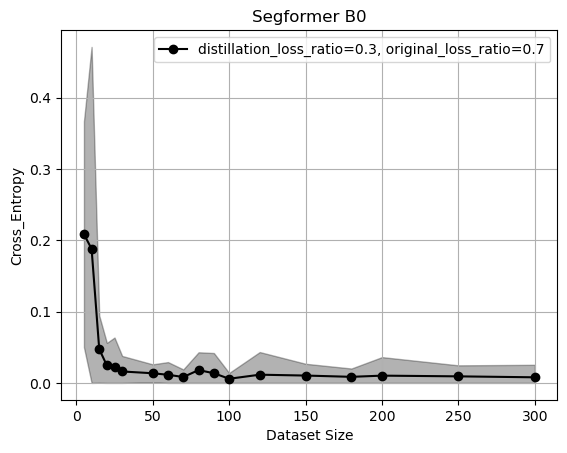

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()